In [31]:
# python library imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns

# machine learning imports
import keras
import tensorflow as tf
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
from tensorflow.keras import backend
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import regularizers
tf.config.run_functions_eagerly(False)

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi']= 100
mpl.rcParams['agg.path.chunksize'] = 10000  
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

import os
os.chdir('/Users/raymondwynne/Desktop/FORCE/python')
from util import trim_trailing_zeros, plot_auc_bs
os.chdir('/Users/raymondwynne/Desktop/FORCE/gauss')

%reload_ext autoreload
%autoreload 2

In [32]:
gauss_results_path = '/Users/raymondwynne/Desktop/FORCE/results/gauss/data/'
gauss_figures_path = '/Users/raymondwynne/Desktop/FORCE/results/gauss/figures/'

In [33]:
signal_mean, signal_variance = 2, 1
background_mean, background_variance = 0, 1

fs = 0.5

background_size = 100000
signal_size = 100000

data_1 = np.random.normal(signal_mean, signal_variance, (signal_size, 2))
data_2 = np.random.normal(background_mean, background_variance, (background_size, 2))

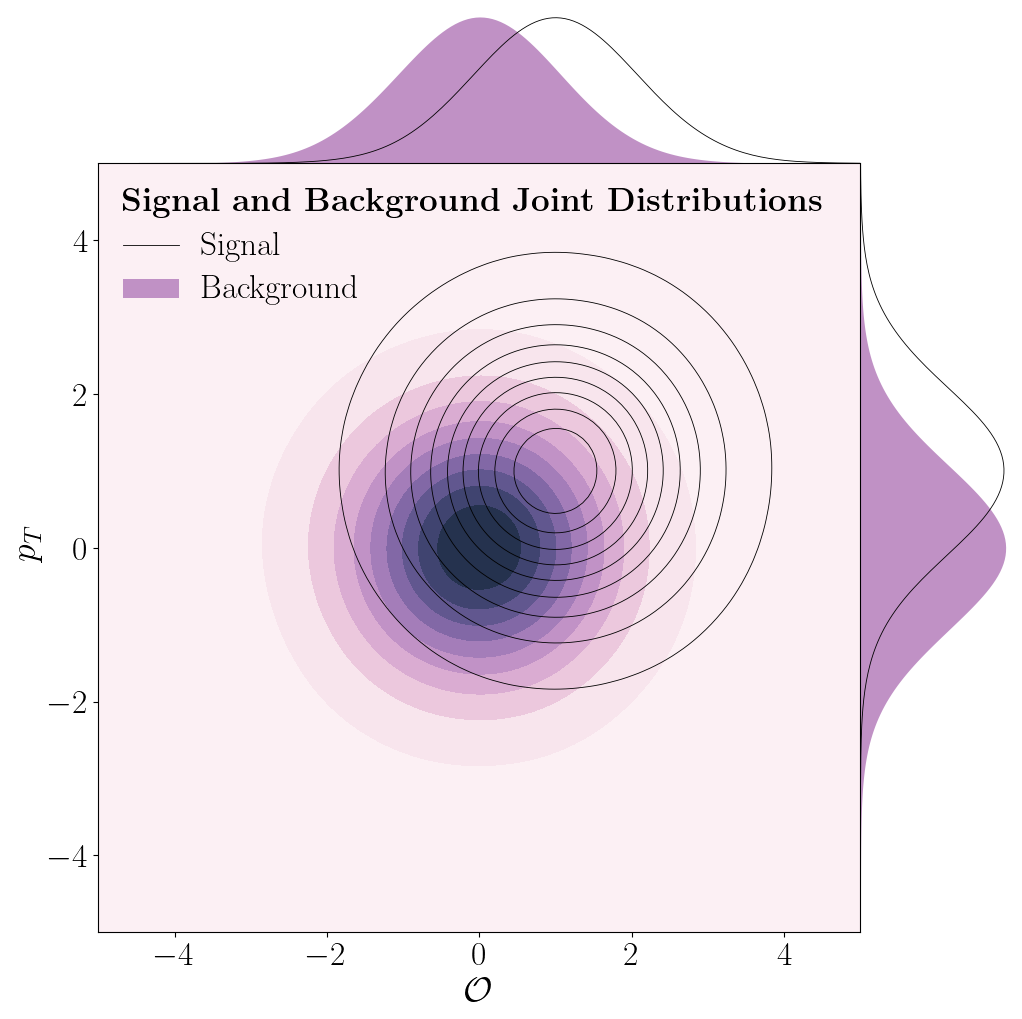

In [34]:
# Parameters of the Gaussians
mu_B, sigma_B = [0, 0], [[1, 0], [0, 1]]  # mean and covariance for the first Gaussian
mu_S, sigma_S = [1, 1], [[1, 0], [0, 1]]  # mean and covariance for the second Gaussian

# Generate samples from two different Gaussian distributions
background = np.random.multivariate_normal(mu_B, sigma_B, 100000)
signal = np.random.multivariate_normal(mu_S, sigma_S, 100000)

# Plotting parameters
c_cut = 5
cmap=sns.cubehelix_palette(start=26/10, light=.97, as_cmap=True)
COL2 = '#000000'
linew = 0.6

# Set the style for the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.autolayout'] = False
plt.rcParams['text.usetex'] = True

# Create the jointplot for the first Gaussian distribution
g = sns.jointplot(x=background[:, 0], y=background[:, 1], color=cmap(100), space=0, label='',
                  cmap=cmap, kind='kde', height=10, fill=True, cut=c_cut,
                  marginal_kws={'linewidth': 0.0, 'alpha': 1.0, 'bw_adjust': 4}, bw_adjust=4)

# Add the second Gaussian distribution to the jointplot
sns.kdeplot(x=signal[:, 0], y=signal[:, 1], fill=False, label=r'ttbar jets', color=COL2, linewidths=linew, cut=c_cut,
            levels=10, ax=g.ax_joint, bw_adjust=4)

# Add the marginal distributions for the second Gaussian
sns.kdeplot(signal[:, 0], ax=g.ax_marg_x, color=COL2, lw=linew, bw_adjust=4)
sns.kdeplot(y=signal[:, 1], ax=g.ax_marg_y, color=COL2, lw=linew, bw_adjust=4)


# Adjust the legend and labels
ax = g.ax_joint
handles = [mlines.Line2D([], [], color=COL2, label=r'Signal', lw=linew),
           mpatches.Patch(facecolor=cmap(100), label=r'Background')]
legend = ax.legend(loc='upper left', handles=handles, frameon=False, title=r'\bf{Signal and Background Joint Distributions}', fontsize=20)
legend._legend_box.align = 'left'
ax.tick_params(axis='both', labelsize=24)  # Change 14 to your desired size
# plt.setp(legend.get_texts(), color=cmap(0.98))
plt.setp(legend.get_texts(), fontsize=24)  # Set a suitable font size, e.g., 12
# Set the font size for the legend title
plt.setp(legend.get_title(), fontsize=24)  # Set a suitable font size, e.g., 14



# Final adjustments and save the figure
ax.set_facecolor(cmap(5))
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
g.ax_marg_y.get_yaxis().set_visible(False)
g.ax_marg_x.get_xaxis().set_visible(False)
g.ax_marg_x.tick_params(axis='x', labelsize=20)  # Change 14 to your desired size
g.ax_marg_y.tick_params(axis='y', labelsize=20)  # Change 14 to your desired size
plt.xlabel(r'$\mathcal{O}$', fontsize=26)
plt.ylabel(r'$p_T$', fontsize=26)
plt.xlim([-5, 5])
plt.ylim([-5, 5])


plt.savefig(gauss_results_path+'gauss_sig_back.pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [35]:
O_s, O_b = data_1[:, 0].reshape(-1, 1), data_2[:, 0].reshape(-1, 1)
p_s, p_b = data_1[:, 1], data_2[:, 1]

In [36]:
from scipy.stats import norm

def likelihood_ratio_function(x): 
    return norm.pdf(x, loc=signal_mean, scale=signal_variance) / norm.pdf(x, loc=background_mean, scale=background_variance)

In [37]:
features_no_sig = O_b
targets_no_sig = p_b
features_sig = np.concatenate((O_b, O_s))
targets_sig = np.concatenate((p_b, p_s))
labels = np.concatenate((np.zeros(len(O_b)), np.ones(len(O_s))))

perm = np.random.permutation(len(labels))

features_sig, targets_sig, labels = features_sig[perm], targets_sig[perm], labels[perm]

## Convergence Plot

In [38]:
nn_conv = pd.read_csv(gauss_results_path + 'gauss_nn_convergence', index_col=0)

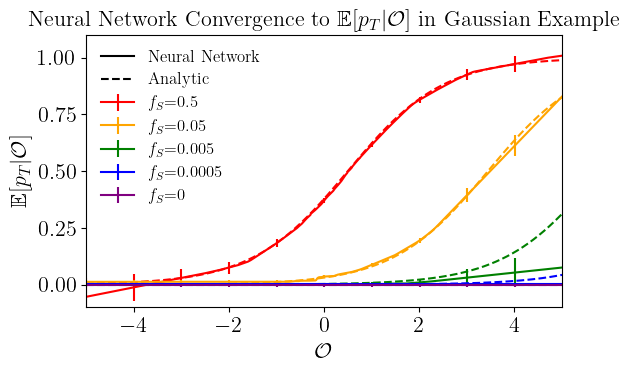

In [39]:
colors = ['red', 'orange', 'green', 'blue', 'purple']

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi']= 100
i = 0

plt.plot([0], [0], color='black', label='Neural Network')
plt.plot([0], [0], color='black', linestyle='dashed', label='Analytic')

for fs in sorted(list(set(nn_conv.fs)), reverse=True):

    nn_conv_fs = nn_conv[nn_conv.fs == fs]
    plt.errorbar(nn_conv_fs.features, nn_conv_fs.mean_nn_signal, nn_conv_fs.std_nn_signal, errorevery=100, c=colors[i], label=r'$f_S$={}'.format(trim_trailing_zeros(fs)))
    # plt.plot(nn_conv_fs.features, nn_conv_fs.mean_nn_signal, label='Neural Network')
    plt.plot(nn_conv_fs.features, nn_conv_fs.cond_exp, linestyle='dashed', c=colors[i])
    plt.xlabel(r'$\mathcal{O}$')
    plt.ylabel(r'$\mathbb{E}[p_T|\mathcal{O}]$')
    plt.xlim([-5, 5])
    plt.ylim([-0.1, 1.1])
    # plt.savefig(gauss_results_path + 'nn_conv_{}.pdf'.format(fs))
    # plt.show()
    i += 1
plt.title('Neural Network Convergence to $\mathbb{E}[p_T|\mathcal{O}]$ in Gaussian Example', fontsize=16)
plt.legend(frameon=False, loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig(gauss_figures_path + 'gauss_nn_convergence.pdf', bbox_inches='tight')
plt.show()

In [40]:
gauss_auc = pd.read_csv(gauss_results_path + 'gauss_auc_sweep', index_col=0)

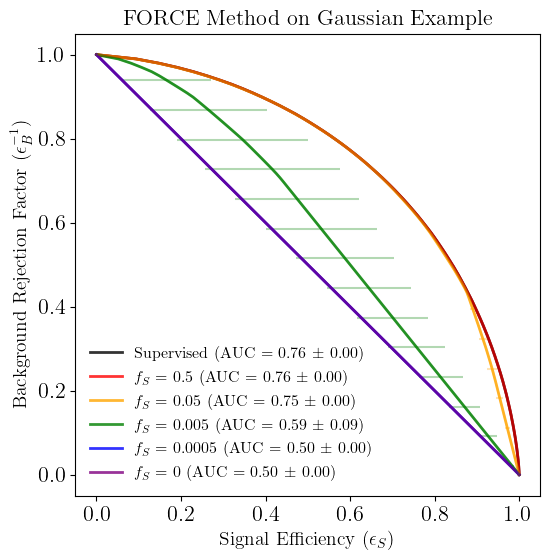

In [41]:
numeric = list(set(gauss_auc.fs))
numeric.remove('Supervised')
sorted_numeric = sorted(numeric, reverse=True)
sweep = ['Supervised'] + sorted_numeric

plot_auc_bs(gauss_auc, sweep, 'FORCE Method on Gaussian Example', save_as=gauss_results_path+'gauss_sweep', gauss=True)